In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1YYcPg4eT9CKR1X3DkYoZdokc24oWyakw' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Daily.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
# Reading data
daily_data = pd.read_csv('ASX200Daily.csv')

In [33]:
# Converting to a time series
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data.set_index('Date', inplace = True)
daily_ts = pd.Series(daily_data['Close'])
print(daily_ts.head())

Date
2000-03-31    3133.300049
2000-04-03    3191.000000
2000-04-04    3176.800049
2000-04-05    3155.399902
2000-04-06    3157.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
daily_ts.dropna(inplace=True)

In [35]:
# Days of the week with closing price given
daily_ts.index.dayofweek.unique()

Int64Index([4, 0, 1, 2, 3, 6], dtype='int64', name='Date')

In [0]:
# Removing rows with day of the week = 6 (Sunday)
# Only taking weekdays into account will give better predictions for this assignment
daily_ts = daily_ts[daily_ts.index.dayofweek!=6]

In [0]:
# Transforming time series by taking log
# It reduces variation in data by penalizing larger values more than the smaller ones
daily_ts = np.log(daily_ts)

In [0]:
# Splitting data into training and validation subsets
training_subset = daily_ts[:-365]
validation_subset = daily_ts[-365:]

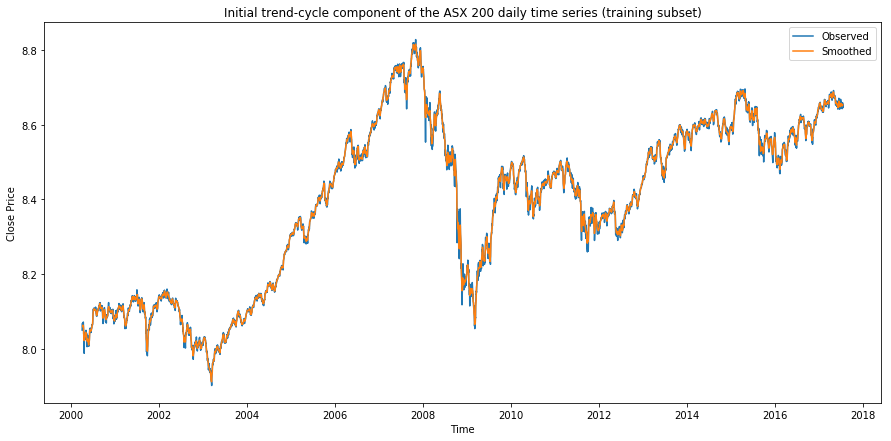

In [44]:
# Smoothing data by using CMA-12 to calculate the initial trend-cycle estimate
trend_cycle = training_subset.rolling(5, center=True).mean()

# Setting figure width and height
rcParams['figure.figsize'] = 15, 7

plt.plot(training_subset, label = "Observed")
plt.plot(trend_cycle, label = "Smoothed")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Initial trend-cycle component of the ASX 200 daily time series (training subset)')
plt.legend()

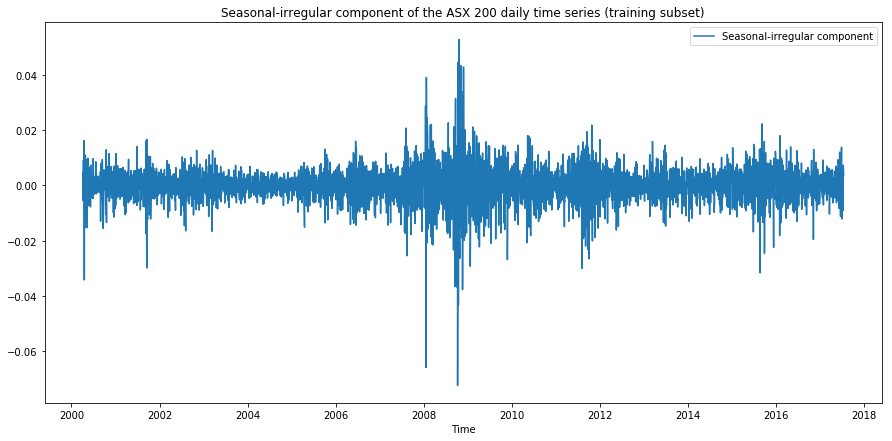

In [45]:
# Calculating the seasonal-irregular component
seasonal = training_subset - trend_cycle

plt.plot(seasonal, label = "Seasonal-irregular component")
plt.xlabel('Time')
plt.title('Seasonal-irregular component of the ASX 200 daily time series (training subset)')
plt.legend()

In [46]:
# Calculating (un-normalized) seasonal indexes
seasonal_indexes = np.empty(5)
for i in range(0,5):
    seasonal_indexes[i] = seasonal[seasonal.index.dayofweek==i].mean()

seasonal_indexes

array([-2.18695477e-04, -5.84172941e-06, -6.42694627e-06,  2.30832810e-04,
       -2.76741527e-06])

In [47]:
# Calculating normalized seasonal indexes
norm_seasonal_indexes = seasonal_indexes - seasonal_indexes.mean()
norm_seasonal_indexes

array([-2.18115725e-04, -5.26197782e-06, -5.84719468e-06,  2.31412561e-04,
       -2.18766367e-06])

In [0]:
# Repeating normalized seasonal indexes for the entire duration
seasonal_components = np.empty(training_subset.size)
for i,j in enumerate(training_subset.index.dayofweek):
    seasonal_components[i] = norm_seasonal_indexes[j]


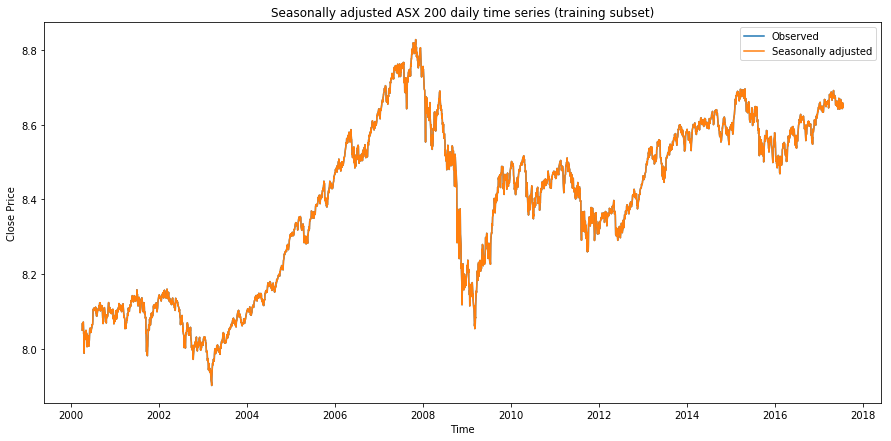

In [49]:
# Calculating seasonally adjusted series
seasonally_adjusted = training_subset - seasonal_components

plt.plot(training_subset, label = "Observed")
plt.plot(seasonally_adjusted, label = "Seasonally adjusted")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Seasonally adjusted ASX 200 daily time series (training subset)')
plt.legend()

In [0]:
# Dataframe for linear regression
daily_df = pd.DataFrame()
daily_df['Time'] = range(1, training_subset.size+1)
daily_df['Close'] = seasonally_adjusted.values
daily_df.head()

,Time,Close
0,1,8.049844
1,2,8.068308
2,3,8.063635
3,4,8.056876
4,5,8.057178


In [0]:
# Creating a linear regression model
lm = LinearRegression()
lm.fit(daily_df[['Time']], daily_df[['Close']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Coefficient and intercept values
coef = lm.coef_[0][0]
intercept = lm.intercept_[0]
print('Coefficient:', coef)
print('Intercept:', intercept)

Coefficient: 0.00014215618516871714
Intercept: 8.107802441789607


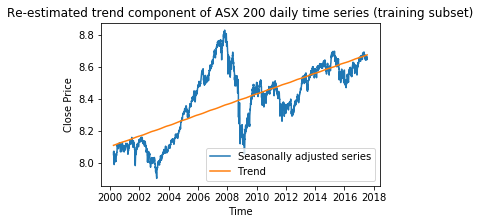

In [0]:
# Re-estimating trend
reestimated_trend = pd.Series(data=(intercept + daily_df['Time']*coef).values, index=seasonally_adjusted.index)

plt.plot(seasonally_adjusted, label = "Seasonally adjusted series")
plt.plot(reestimated_trend, label = "Trend")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Re-estimated trend component of ASX 200 daily time series (training subset)')
plt.legend()

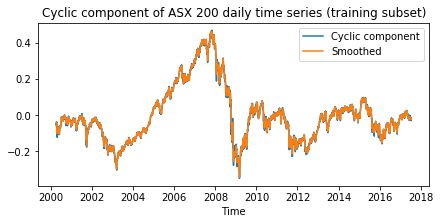

In [0]:
# Estimating cyclic component
trend_seasonal = reestimated_trend + seasonal_components
cyclic_component = training_subset - trend_seasonal

# Removing noise by smoothing data (MA-3)
cyclic = cyclic_component.rolling(3, center=True).mean()

plt.plot(cyclic_component, label = "Cyclic component")
plt.plot(cyclic, label = "Smoothed")
plt.xlabel('Time')
plt.title('Cyclic component of ASX 200 daily time series (training subset)')
plt.legend()

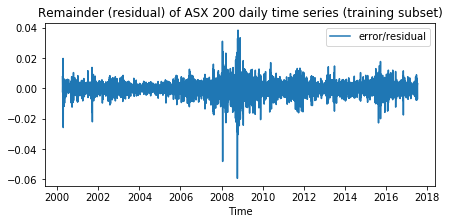

In [0]:
# Calculating remainder
remainder = training_subset - (cyclic + reestimated_trend + seasonal_components)

plt.plot(remainder, label = "error/residual")
plt.xlabel('Time')
plt.title('Remainder (residual) of ASX 200 daily time series (training subset)')
plt.legend()

In [0]:
# Forecasting 'Close' price for next 365 days (validation subset)

training_ts = reestimated_trend + seasonal_components

t = np.empty(validation_subset.size)
for i in range(0,validation_subset.size):
    t[i] = intercept + (training_subset.size+1+i)*coef

seasonal = daily_ts - trend_cycle
seasonal_components = np.empty(daily_ts.size)
for i,j in enumerate(daily_ts.index.dayofweek):
    seasonal_components[i] = norm_seasonal_indexes[j]

predictions = validation_subset.copy()
for i in range(0,predictions.size):
    predictions[i] = t[i] + seasonal_components[training_subset.size+i]

In [0]:
# Appending fitted values with the predicted values
predicted_ts = training_ts.append(predictions)

In [0]:
# Returning data to its original form by taking inverse of log
predicted_ts = np.exp(predicted_ts)
daily_ts = np.exp(daily_ts)
training_subset = np.exp(training_subset)
training_ts = np.exp(training_ts)
validation_subset = np.exp(validation_subset)
predictions = np.exp(predictions)

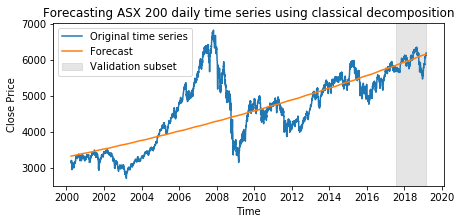

In [0]:
plt.plot(daily_ts, label = "Original time series")
plt.plot(predicted_ts, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 daily time series using classical decomposition')
plt.legend()

In [0]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts))
MAE = mean_absolute_error(training_subset, training_ts)
MAPE = np.mean(np.abs((training_subset - training_ts) / training_subset)) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 702.702335944282
Mean Absolute Error (MAE): 494.13242052499305
Mean Absolute Percentage Error (MAPE): 10.812683760407776


In [0]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions))
MAE = mean_absolute_error(validation_subset, predictions)
MAPE = np.mean(np.abs((validation_subset - predictions) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 201.33854559264685
Mean Absolute Error (MAE): 158.80817199201297
Mean Absolute Percentage Error (MAPE): 2.6946975837352842
